In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding, MDS
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans, MeanShift, Birch
from sklearn.decomposition import PCA, SparsePCA
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

### 5-fold cross validation
#### Almost all experiments below have to be done using cross validation!!!

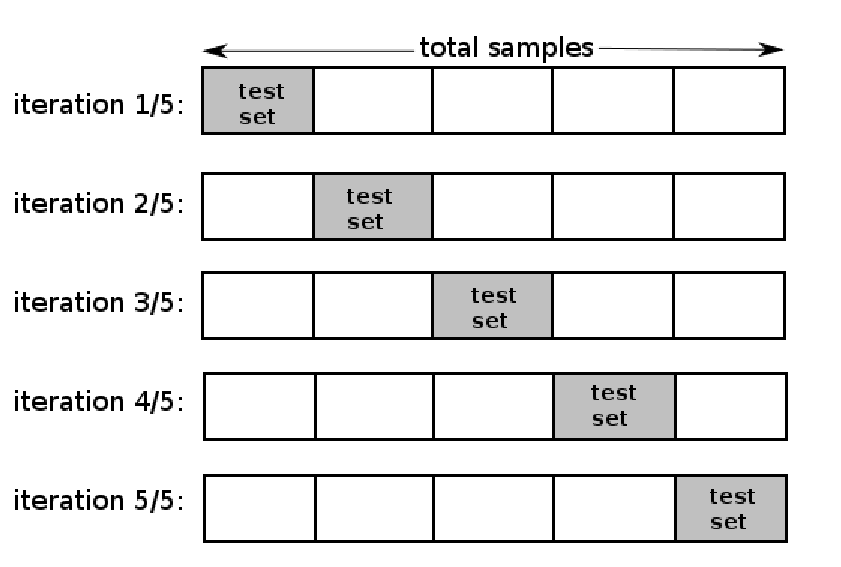

In [2]:
Image(filename="./addition/cross_validation.png", width=700, height=700)

### Load, preprocess and split the data

In [3]:
train = pd.read_csv('./train.csv', index_col='id')
test = pd.read_csv('./test.csv', index_col='id')

le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])

print(train.shape, test.shape)

(61878, 94) (144368, 93)


In [4]:
X_train, X_val, y_train, y_val = \
        train_test_split(train[train.columns[:-1]], train[train.columns[-1]], test_size=0.2, random_state=23)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(49502, 93) (12376, 93) (49502,) (12376,)


### Clustering and manifold algorithms

In [5]:
def get_manifold_alg_by_name(name, n_components=2):
    if (name == 'tsne'):
        m = TSNE(n_components=n_components)
    elif (name == 'isomap'):
        m = Isomap(n_jobs=8, n_components=n_components)
    elif (name == 'lle'):
        m = LocallyLinearEmbedding(n_jobs=8,n_components=n_components)
    elif (name == 'spectral'):
        m = SpectralEmbedding(n_jobs=8,n_components=n_components)
    elif (name == 'mds'):
        m = MDS(n_jobs=8, n_components=n_components)
    return m

def plot_and_save_manifold_colorbar(y, result, algo_name, projection, save_path):
    plt.rcParams['image.cmap'] = 'jet'
    fig = plt.figure(figsize=(12,12))
    if (projection == '3d'):
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(result[:,0], result[:,1],result[:,2], s = 50, c = y)
    else:
        ax = fig.add_subplot(111)
        p = ax.scatter(result[:,0], result[:,1], s = 50, c = y)
    title = "{} algorithm".format(algo_name)
    plt.title(title, fontsize=18, fontweight = 'bold')
    p.set_array(y)
    fig.colorbar(p)
    ax.grid(True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

def get_cluster_alg_by_name(name, n_clusters):
    if (name == 'agglomerative_clustering'):
        m = AgglomerativeClustering(n_clusters=n_clusters)
    elif (name == 'dbscan'):
        m = DBSCAN(n_jobs=20)
    elif (name == 'kmeans'):
        m = MiniBatchKMeans(n_clusters=n_clusters)
    elif (name == 'meanshift'):
        m = MeanShift(n_jobs=20)
    elif (name == 'birch'):
        m = Birch(n_clusters=int(n_clusters))
    return m

def plot_and_save_clusters_colorbar(y, predicted, target, name, save_path):
    df = pd.DataFrame()
    df['Cluster'] = predicted
    df['Sample'] = np.arange(len(y))
    df[target] = y
    fig = plt.figure(figsize=(10,8))
    plt.title("{}\n{} algorithm".format(target, name), fontsize=18)
    cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
    norm = matplotlib.colors.Normalize(vmin=min(y), vmax=max(y))
    colors = {}
    for cval in y:
        colors.update({cval : cmap(norm(cval))})
    sns.swarmplot(x='Cluster', y='Sample', hue=target, data=df,palette = colors)
    plt.gca().legend_.remove()
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig.add_axes(ax_cb)
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation='vertical')
    plt.ylabel("Sample", fontsize=16)
    cb1.set_label(target)
    n_clusters = max(predicted) + 1
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

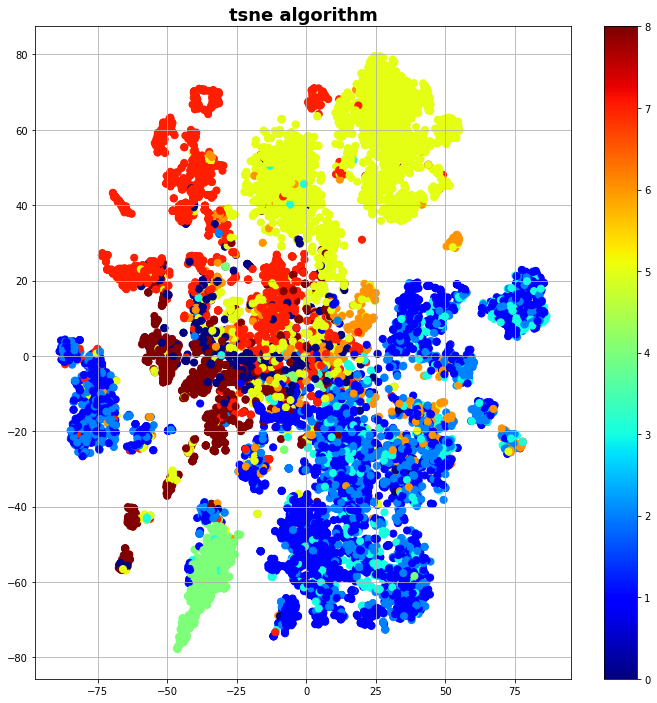

In [6]:
tsne = get_manifold_alg_by_name('tsne')
tsne_train = tsne.fit_transform(X_val)
plot_and_save_manifold_colorbar(y_val, tsne_train, 'tsne', '2d', './images/tsne_train.png')

/Users/alexeygrachev/git/kaggle/venv/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


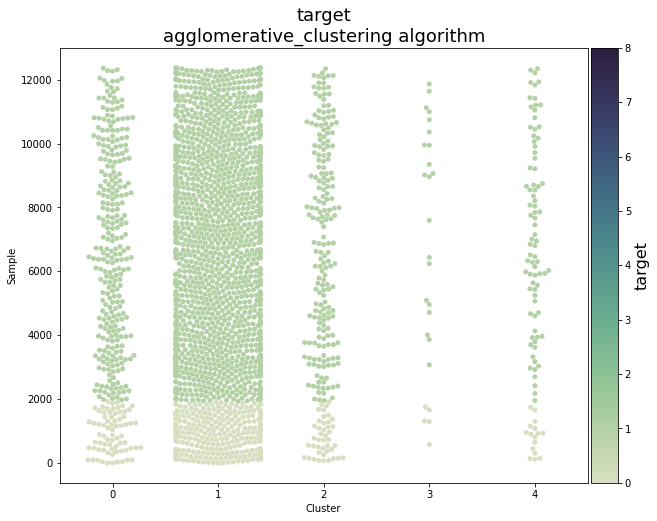

In [7]:
dbscan = get_cluster_alg_by_name('agglomerative_clustering', n_clusters=5)
dbscan_train = dbscan.fit_predict(X_val)
plot_and_save_clusters_colorbar(y_val, dbscan_train, 'target', 'agglomerative_clustering', './images/agglomerative_clustering_train.png')

### PCA for feature extraction

In [8]:
pca = PCA(n_components=0.95)
pca_train = pca.fit_transform(train[train.columns[:-1]])
print('{0} components preserve 95% of total variance'.format(pca.n_components_))

57 components preserve 95% of total variance


### Autoencoder for feature extraction

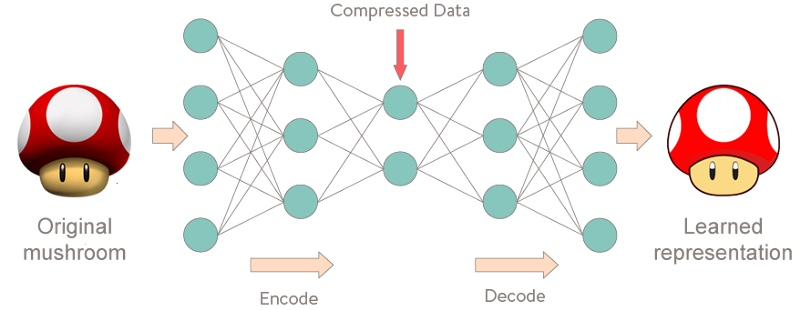

In [9]:
Image(filename="./addition/ae.png", width=800, height=800)

In [10]:
input_dim = 93

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats

# this is our input placeholder
model_input = Input(shape=(input_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(model_input)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='relu')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(model_input, decoded)

# this model maps an input to its encoded representation
encoder = Model(model_input, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# compile model
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(X_train.values, X_train.values,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val.values, X_val.values))

Epoch 1/50
194/194 [==============================] - 1s 5ms/step - loss: 6.7665 - val_loss: 6.4851
Epoch 2/50
194/194 [==============================] - 0s 2ms/step - loss: 6.8756 - val_loss: 6.4701
Epoch 3/50
194/194 [==============================] - 0s 1ms/step - loss: 6.9181 - val_loss: 6.4555
Epoch 4/50
194/194 [==============================] - 1s 3ms/step - loss: 6.6850 - val_loss: 6.4410
Epoch 5/50
194/194 [==============================] - 0s 3ms/step - loss: 6.5777 - val_loss: 6.4266
Epoch 6/50
194/194 [==============================] - 0s 2ms/step - loss: 6.8272 - val_loss: 6.4123
Epoch 7/50
194/194 [==============================] - 0s 1ms/step - loss: 6.6078 - val_loss: 6.3984
Epoch 8/50
194/194 [==============================] - 0s 2ms/step - loss: 6.5151 - val_loss: 6.3845
Epoch 9/50
194/194 [==============================] - 0s 2ms/step - loss: 6.8632 - val_loss: 6.3709
Epoch 10/50
194/194 [==============================] - 0s 1ms/step - loss: 6.6157 - val_loss: 6.3574

In [11]:
encoded_val = encoder.predict(X_val.values)
print(encoded_val.shape)

(12376, 32)


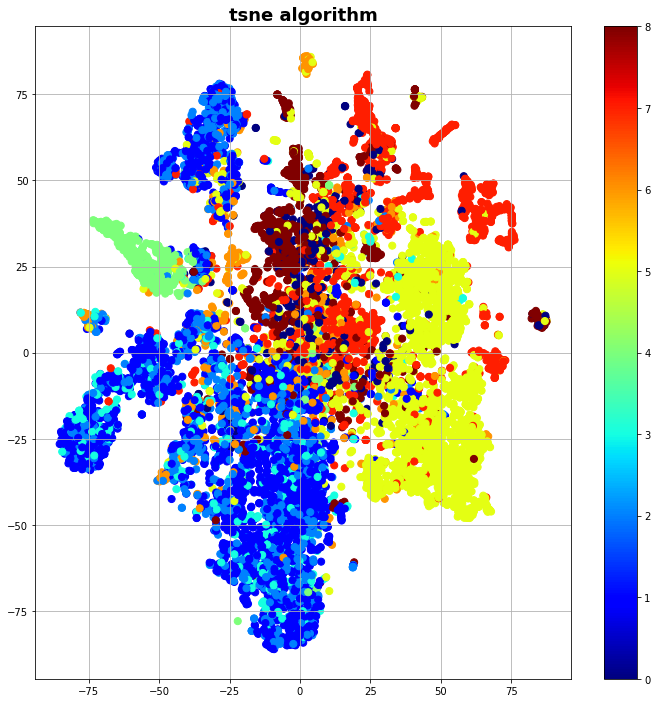

In [12]:
tsne = get_manifold_alg_by_name('tsne')
tsne_encoded = tsne.fit_transform(encoded_val)
plot_and_save_manifold_colorbar(y_val, tsne_encoded, 'tsne', '2d', './images/tsne_encoded.png')

### RandomForest for feature selection

In [13]:
num_of_most_important_features = 20
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

five_most_important_features = [X_train.columns[indices[f]] for f in range(num_of_most_important_features)]
five_most_important_features.append('target')

selected_train = train.loc[:,five_most_important_features]
print(selected_train.shape) # after selection we can train new model on the selected features

(61878, 21)


### Postprocessing analysis via confussion matrix

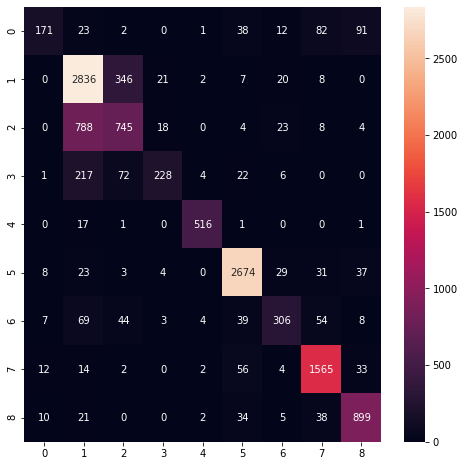

In [14]:
conf_mat = confusion_matrix(y_val, forest.predict(X_val))

plt.figure(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.savefig("./images/confussion_matrix.png", dpi=300)

# Tips & tricks

### Calibration

In [15]:
print("loss without calibration: {0}".format(log_loss(y_val, forest.predict_proba(X_val), eps=1e-15, normalize=True)))

calibrated_clf = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), method='isotonic', cv=5)
calibrated_clf.fit(X_train, y_train)
print("loss with calibration: {0}".format(log_loss(y_val, calibrated_clf.predict_proba(X_val), eps=1e-15, normalize=True)))

loss without calibration: 0.6364123987756515
loss with calibration: 0.49520462527383796


### Balancing data

In [16]:
sm = SMOTE()
X_train_augmented, y_train_augmented = sm.fit_resample(X_train, y_train)
print('Original data: {0}'.format(X_train.shape))
print('Augmented data: {0}'.format(X_train_augmented.shape))

Original data: (49502, 93)
Augmented data: (115938, 93)


#### What was missed from this part:
1. Optimal threshold technique.
2. Model selection using bayes_opt, hyperopt
3. Feature selection via DFS, PFI, clustering.
4. Hand-crafted feature engineering.